### 패션 의류 분류 경진대회

### 데이터 준비

In [2]:
cd /content/drive/MyDrive/class/vision study/kfashion

/content/drive/MyDrive/class/vision study/kfashion


In [5]:
!unzip fashion_mnist.zip

Archive:  fashion_mnist.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


### 라이브러리 호출

In [94]:
import pandas as pd
import numpy as np
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Conv2D
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Adamax
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 데이터 불러오기

In [50]:
train = pd.read_csv("./data/train.csv").iloc[:, 1:] # index 열 미리 제거
test = pd.read_csv("./data/test.csv").iloc[:, 1:] 
sub = pd.read_csv("./data/sample_submission.csv")

### 전처리

In [51]:
x = np.array(train.drop('label', axis = 1), dtype = 'float32')
y = train.label

In [52]:
x = x.reshape(-1, 28,28,1)
test = test.values.reshape(-1, 28,28,1)

In [56]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [54]:
print(x_train.shape)
print(x_valid.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)


#### 스케일링

In [57]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1).astype('float32') / 255

#### 원 핫 인코딩

In [60]:
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)

### 이미지 확인

In [66]:
num = random.randint(1, len(y))

23613번 클래스 의류


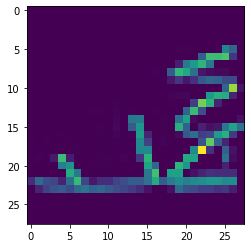

In [67]:
image = x[num,:].reshape(28,28)
print(f'{num}번 클래스 의류')
plt.imshow(image)
plt.show()

### 모델 구조 생성

In [83]:
model = Sequential()

# CONV1
model.add(Conv2D(256, kernel_size = (3,3), input_shape=(28,28,1), activation='elu'))
model.add(BatchNormalization())
# CONV2
model.add(Conv2D(128,(3,3), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

# FC
model.add(Flatten())
model.add(Dense(32, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

### 콜백 함수 선언

In [84]:
reLR = ReduceLROnPlateau(patience = 5,verbose = 1,factor = 0.5) 
es = EarlyStopping(patience = 5, verbose=1, monitor = 'val_accuracy', mode = "max") 

### 모델 학습

In [85]:
model.compile(loss = 'categorical_crossentropy',
              optimizer=Adamax(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [86]:
history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
                    epochs=20, 
                    batch_size=64, 
                    verbose=1, 
                    callbacks=[reLR, es])

print("\n Test loss: %.4f" % (model.evaluate(x_valid, y_valid)[0]))
print("\n Test Accuracy: %.4f" % (model.evaluate(x_valid, y_valid)[1]))

Epoch 1/20
750/750 [==============================] - 15s 18ms/step - loss: 0.7807 - accuracy: 0.7417 - val_loss: 0.4468 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 2/20
750/750 [==============================] - 13s 18ms/step - loss: 0.5503 - accuracy: 0.8120 - val_loss: 0.3754 - val_accuracy: 0.8724 - lr: 0.0010
Epoch 3/20
750/750 [==============================] - 13s 18ms/step - loss: 0.4688 - accuracy: 0.8379 - val_loss: 0.3445 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 4/20
750/750 [==============================] - 13s 18ms/step - loss: 0.4130 - accuracy: 0.8554 - val_loss: 0.3420 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 5/20
750/750 [==============================] - 13s 18ms/step - loss: 0.3819 - accuracy: 0.8677 - val_loss: 0.3085 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 6/20
750/750 [==============================] - 13s 18ms/step - loss: 0.3552 - accuracy: 0.8754 - val_loss: 0.3087 - val_accuracy: 0.8965 - lr: 0.0010
Epoch 7/20
750/750 [==============================] - 13s 

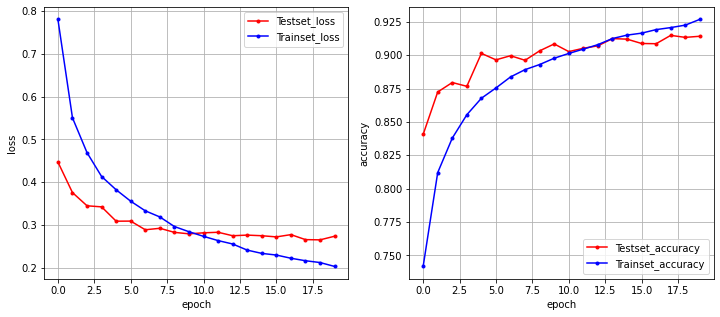

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# 오차
y_vloss = history.history['val_loss']

# 학습셋 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
ax1.plot(x_len, y_vloss, marker = '.', c="red", label='Testset_loss')
ax1.plot(x_len, y_loss, marker = '.', c='blue', label = 'Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
ax1.legend(loc='upper right')
ax1.grid()
ax1.set(xlabel='epoch', ylabel='loss')


# 정확도
y_vaccuracy = history.history['val_accuracy']

# 학습셋
y_accuracy = history.history['accuracy']

# 그래프로 표현
x_len = np.arange(len(y_accuracy))
ax2.plot(x_len, y_vaccuracy, marker = '.', c="red", label='Testset_accuracy')
ax2.plot(x_len, y_accuracy, marker = '.', c='blue', label = 'Trainset_accuracy')

# 그래프에 그리드를 주고 레이블을 표시
ax2.legend(loc='lower right')
ax2.grid()

ax2.set(xlabel='epoch', ylabel='accuracy')

# draw gridlines
ax2.grid(True)
plt.show()

In [88]:
y_pred = model.predict(x_valid).round(2)

y_val_label = list(map(np.argmax, y_valid))
y_pred_label = list(map(np.argmax, y_pred))

375/375 [==============================] - 1s 3ms/step


In [90]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

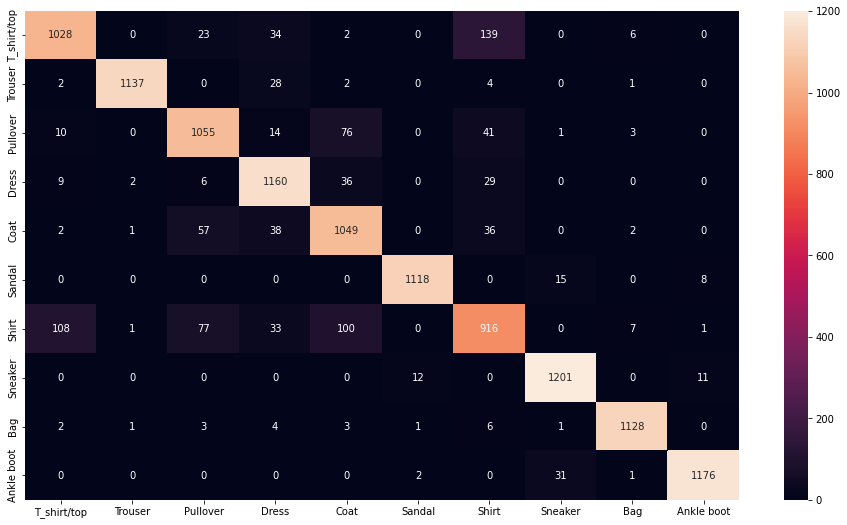

In [95]:
plt.figure(figsize = (16,9))

cm = confusion_matrix(y_val_label,y_pred_label)

sns.heatmap(cm , annot = True,fmt = 'd',xticklabels = class_names,yticklabels = class_names)

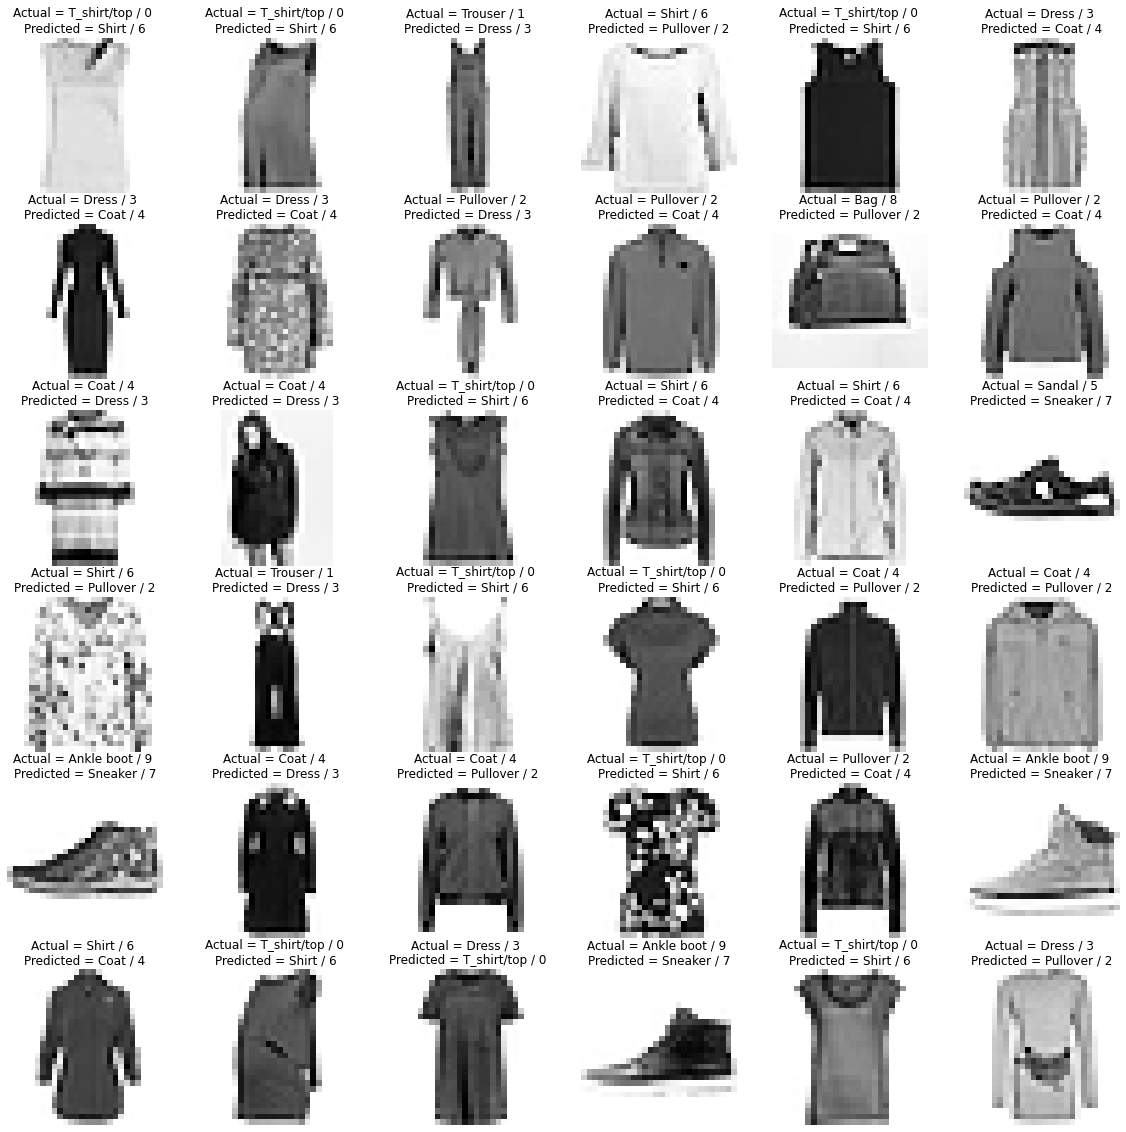

In [97]:
aaa = np.array(y_val_label) != np.array(y_pred_label)

not_equel_list = np.where(aaa == True)[0]

plt.figure(figsize=(20,20))
j = 1
for i in not_equel_list[0:36]:
# for a in np.random.randint(0,206,36):
#     i = not_equel_list[a]
#     print(a)
    plt.subplot(6,6,j); j+=1
    plt.imshow(x_valid[i].reshape(28,28),cmap = 'Greys')
    plt.axis('off')
    plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(class_names[y_val_label[i]],
                                                            y_val_label[i],
                                                            class_names[y_pred_label[i]],
                                                            y_pred_label[i]))

In [104]:
results = model.predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

313/313 [==============================] - 1s 3ms/step


In [105]:
results

0       0
1       1
2       6
3       0
4       3
       ..
9995    0
9996    6
9997    8
9998    8
9999    1
Name: Label, Length: 10000, dtype: int64

In [107]:
sub

,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
9995,9995,0
9996,9996,0
9997,9997,0
9998,9998,0


In [108]:
sub['label'] = results

In [110]:
sub.to_csv("fashion_mnist_submissin.csv", index = False)

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("results_fashion_mnist.csv",index=False)